## AB TESTING PROJECT FOR ONLINE ADVERTISING
A firm want to know between two awareness method, which is the most effective on purchase. so they decided to share their customers into two groups. one group were exposed to  **public service Anouncement (Psa)** others were exposed to **Advertisment (ad)** which included web page, page element, banner, etc. This experiment was carried out for a period of 30 days.

## META DATA
1) No of columns = 6
2) No of rows = 2000

* Columns

1) cutomerID dtype int
2) test group dtype string
3) made_purchase  dtype Boolean
4) days_with_most_add dtype int
5) peak ad hours dtype int
6) ad_count dtype int

In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

In [306]:
# importing the file
Advert_data = pd.read_csv('online_ad_AB.csv')
Advert_data.head()

,customerID,test group,made_purchase,days_with_most_add,peak ad hours,ad_count
0,1,ad,False,24,20,5
1,2,psa,False,21,16,9
2,3,psa,False,1,18,8
3,4,ad,False,20,23,7
4,5,ad,False,3,13,5


In [307]:
Advert_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customerID          20000 non-null  int64 
 1   test group          20000 non-null  object
 2   made_purchase       20000 non-null  bool  
 3   days_with_most_add  20000 non-null  int64 
 4   peak ad hours       20000 non-null  int64 
 5   ad_count            20000 non-null  int64 
dtypes: bool(1), int64(4), object(1)
memory usage: 800.9+ KB


In [308]:
Advert_data.shape

(20000, 6)

#### The data seems to have no null value. I will confirm better during data cleaning the peak ad hours column is just an int. I wll need to convert it to time and create a column to create a column to contain morning, Afternoon, night and midnight.

## EXPLORATORY DATA ANALYSIS

In [309]:
# To know the Number of days this test took place
Advert_data['days_with_most_add'].nunique()

30

#### The experiment was done for 30 days.

In [310]:
# To know maximum and Minimum Number of adds
Max_ad = Advert_data['ad_count'].max()
Min_ad = Advert_data['ad_count'].min()

print(Max_ad, Min_ad)

10 1


#### Maximum Ad is 10 and Minimum is 1

In [311]:
# checking unique hours
Advert_data['peak ad hours'].unique()

array([20, 16, 18, 23, 13, 22, 19, 15, 21, 11, 10, 17,  1,  3,  8,  2,  0,
        5,  9,  7, 12,  4,  6], dtype=int64)

## DATA CLEANING

In [312]:
Advert_data.isna().sum()

customerID            0
test group            0
made_purchase         0
days_with_most_add    0
peak ad hours         0
ad_count              0
dtype: int64

#### There is no null value

In [313]:
Advert_data[Advert_data.duplicated()]

,customerID,test group,made_purchase,days_with_most_add,peak ad hours,ad_count


#### There are no duplicated values.

### Converting Hour column to Time

In [314]:
# converting 'peak ad hours' to time format.
Advert_data['peak ad hours'] = pd.to_datetime(Advert_data['peak ad hours'], format = '%H')
Advert_data.head()

,customerID,test group,made_purchase,days_with_most_add,peak ad hours,ad_count
0,1,ad,False,24,1900-01-01 20:00:00,5
1,2,psa,False,21,1900-01-01 16:00:00,9
2,3,psa,False,1,1900-01-01 18:00:00,8
3,4,ad,False,20,1900-01-01 23:00:00,7
4,5,ad,False,3,1900-01-01 13:00:00,5


In [315]:
# Date was added but I only need time
Advert_data['peak ad hours'] = pd.to_datetime(Advert_data['peak ad hours'], format='%H:%M').dt.time
Advert_data.head()

,customerID,test group,made_purchase,days_with_most_add,peak ad hours,ad_count
0,1,ad,False,24,20:00:00,5
1,2,psa,False,21,16:00:00,9
2,3,psa,False,1,18:00:00,8
3,4,ad,False,20,23:00:00,7
4,5,ad,False,3,13:00:00,5


#### I now have the hours I needed 

In [316]:
# Creating a column for date times of the day (Morning, Afternoon, Night and midnight)
def time_to_daypart(time):
    if time == pd.to_datetime('00:00',format='%H:%M').time():
        return 'Midnight'
    elif(time > pd.to_datetime('00:00',format='%H:%M').time()) & (time <= pd.to_datetime('06:00',format='%H:%M').time()):
        return 'Early Morning'
    elif(time > pd.to_datetime('06:00',format='%H:%M').time()) & (time <= pd.to_datetime('12:00',format='%H:%M').time()):
        return 'Morning'
    elif(time > pd.to_datetime('12:00',format='%H:%M').time()) & (time <= pd.to_datetime('16:00',format='%H:%M').time()):
        return 'Afternoon'
    elif(time > pd.to_datetime('16:00',format='%H:%M').time()) & (time <= pd.to_datetime('18:00',format='%H:%M').time()):
        return 'Evening'
    else:
        return 'Night'

Advert_data['daypart'] = Advert_data['peak ad hours'].apply(time_to_daypart)




In [317]:
# checking for the new column
Advert_data.head()

,customerID,test group,made_purchase,days_with_most_add,peak ad hours,ad_count,daypart
0,1,ad,False,24,20:00:00,5,Night
1,2,psa,False,21,16:00:00,9,Afternoon
2,3,psa,False,1,18:00:00,8,Evening
3,4,ad,False,20,23:00:00,7,Night
4,5,ad,False,3,13:00:00,5,Afternoon


In [318]:
# checking if there are any other value for the new column except for the ones I have given.
Advert_data['daypart'].unique()

array(['Night', 'Afternoon', 'Evening', 'Morning', 'Early Morning',
       'Midnight'], dtype=object)

## MORE EXPLORATORY DATA ANALYSIS

In [319]:
# Total advert and puplic service Anouncement.
pd.DataFrame(Advert_data['test group'].value_counts())

,count
test group,
ad,12053
psa,7947


In [320]:
pd.DataFrame(Advert_data.groupby(['test group','made_purchase'])['made_purchase'].count())

made_purchase
test group made_purchase               
ad         False                  11250
           True                     803
psa        False                   7690
           True                     257

#### Generally, Few People made purchase for the two programs 

<Axes: xlabel='test group', ylabel='count'>

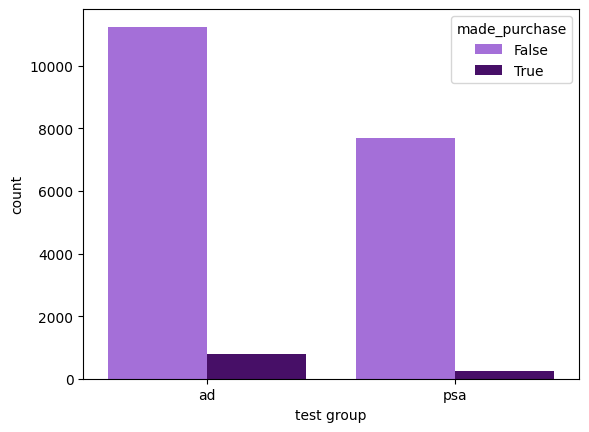

In [321]:
color_palette = ['#A45EE9','#4B0076']
sns.countplot(x= 'test group', hue = 'made_purchase', palette= color_palette, data = Advert_data)

In [322]:
grouped_by_test_group = pd.DataFrame(Advert_data.groupby(['test group','made_purchase']).size()).reset_index()
grouped_by_test_group = grouped_by_test_group.pivot(index = 'test group', columns = 'made_purchase',values = 0)
grouped_by_test_group.columns.name = None
grouped_by_test_group = grouped_by_test_group.rename(columns = {False : 'unsuccessful', True : 'successful'})
grouped_by_test_group.head()

,unsuccessful,successful
test group,,
ad,11250,803
psa,7690,257


In [323]:
grouped_by_test_group = grouped_by_test_group.reset_index()
grouped_by_test_group

,test group,unsuccessful,successful
0,ad,11250,803
1,psa,7690,257


#### The ratio of unsessful per program

([<matplotlib.patches.Wedge at 0x24893df6690>,
 [Text(-0.4312781206561038, -1.0119284473930652, 'ad'),
  Text(0.4312782153996809, 1.0119284070138888, 'psa')],
 [Text(-0.2352426112669657, -0.5519609713053082, '59.4%'),
  Text(0.23524266294528048, 0.5519609492803029, '40.6%')])

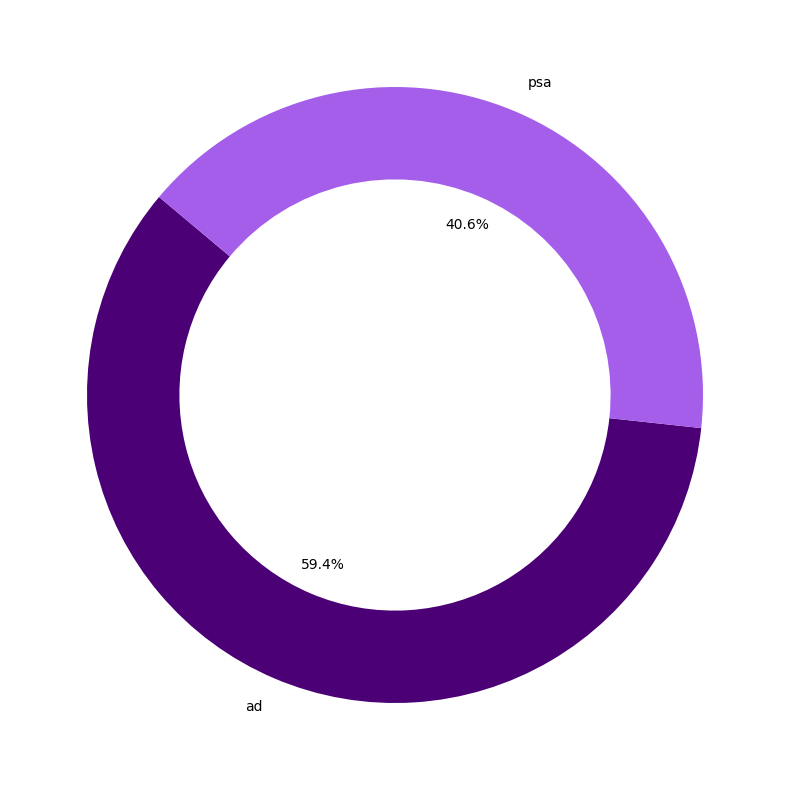

In [324]:
color_palette = ['#4B0076','#A45EE9']

plt.figure(figsize = (20,10))
plt.pie(grouped_by_test_group['unsuccessful'],labels = grouped_by_test_group['test group'], colors = color_palette, autopct = '%1.1f%%', startangle = 140,
                             wedgeprops = dict(width = 0.3))

#### The Ratio of Successful

([<matplotlib.patches.Wedge at 0x2489982c850>,
 [Text(0.12182373391986805, -1.093233267813334, 'ad'),
  Text(-0.12182363156398186, 1.0932332792192907, 'psa')],
 [Text(0.06644930941083711, -0.5963090551709095, '75.8%'),
  Text(-0.06644925358035374, 0.5963090613923403, '24.2%')])

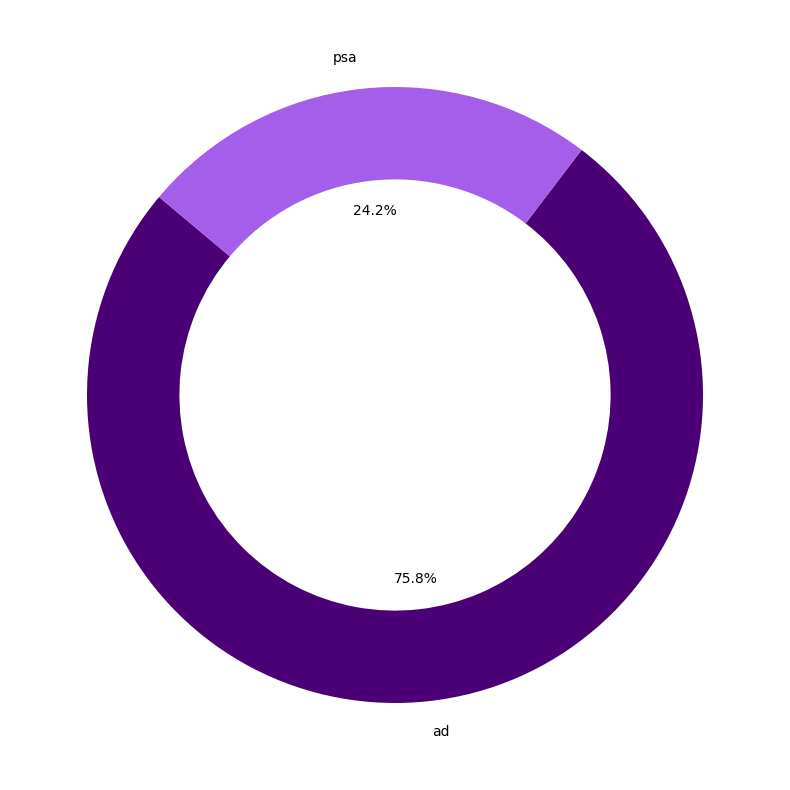

In [325]:
color_palette = ['#4B0076','#A45EE9']

plt.figure(figsize = (20,10))
plt.pie(grouped_by_test_group['successful'],labels = grouped_by_test_group['test group'], colors = color_palette, autopct = '%1.1f%%', startangle = 140,
                             wedgeprops = dict(width = 0.3))

In [326]:
#Hour of the day pivot
hourly_Purchase = pd.DataFrame(Advert_data.groupby('peak ad hours')['made_purchase'].value_counts().reset_index())
hourly_Purchase.head()

,peak ad hours,made_purchase,count
0,00:00:00,False,355
1,00:00:00,True,25
2,01:00:00,False,333
3,01:00:00,True,18
4,02:00:00,False,349


In [327]:
# Let me put these in a pivot table
pivoted_hourly_purchase = hourly_Purchase.pivot(index= 'peak ad hours', columns= 'made_purchase', values = 'count').fillna(0)
pivoted_hourly_purchase.columns.name = None #This removed the 'made_purchase' name above the hour index.
pivoted_hourly_purchase.head()

,False,True
peak ad hours,,
00:00:00,355,25
01:00:00,333,18
02:00:00,349,17
03:00:00,328,14
04:00:00,367,12


In [328]:
pivoted_hourly_purchase = pivoted_hourly_purchase.rename(columns= {True: 'successful_purchase', False : 'unsuccessful_purchase'})
pivoted_hourly_purchase.head()

,unsuccessful_purchase,successful_purchase
peak ad hours,,
00:00:00,355,25
01:00:00,333,18
02:00:00,349,17
03:00:00,328,14
04:00:00,367,12


In [329]:
def is_convertable(valuess): #This helped me find out that my supposed time column is in date time format. I neeed only time 
    try: 
        pd.to_datetime(val, format = '%H:%M')
        return True
    except:
        return False

non_convertable = [time for time in pivoted_hourly_purchase.index if not is_convertable(time)]

print(non_convertable)


[datetime.time(0, 0), datetime.time(1, 0), datetime.time(2, 0), datetime.time(3, 0), datetime.time(4, 0), datetime.time(5, 0), datetime.time(6, 0), datetime.time(7, 0), datetime.time(8, 0), datetime.time(9, 0), datetime.time(10, 0), datetime.time(11, 0), datetime.time(12, 0), datetime.time(13, 0), datetime.time(15, 0), datetime.time(16, 0), datetime.time(17, 0), datetime.time(18, 0), datetime.time(19, 0), datetime.time(20, 0), datetime.time(21, 0), datetime.time(22, 0), datetime.time(23, 0)]


In [330]:
pivoted_hourly_purchase = pivoted_hourly_purchase.reset_index()
pivoted_hourly_purchase.head()

,peak ad hours,unsuccessful_purchase,successful_purchase
0,00:00:00,355,25
1,01:00:00,333,18
2,02:00:00,349,17
3,03:00:00,328,14
4,04:00:00,367,12


In [331]:
#I need to convert my time to string so as to make a plot
pivoted_hourly_purchase['peak ad hours'] = pivoted_hourly_purchase['peak ad hours'].astype(str)


In [332]:
pivoted_hourly_purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   peak ad hours          23 non-null     object
 1   unsuccessful_purchase  23 non-null     int64 
 2   successful_purchase    23 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 684.0+ bytes


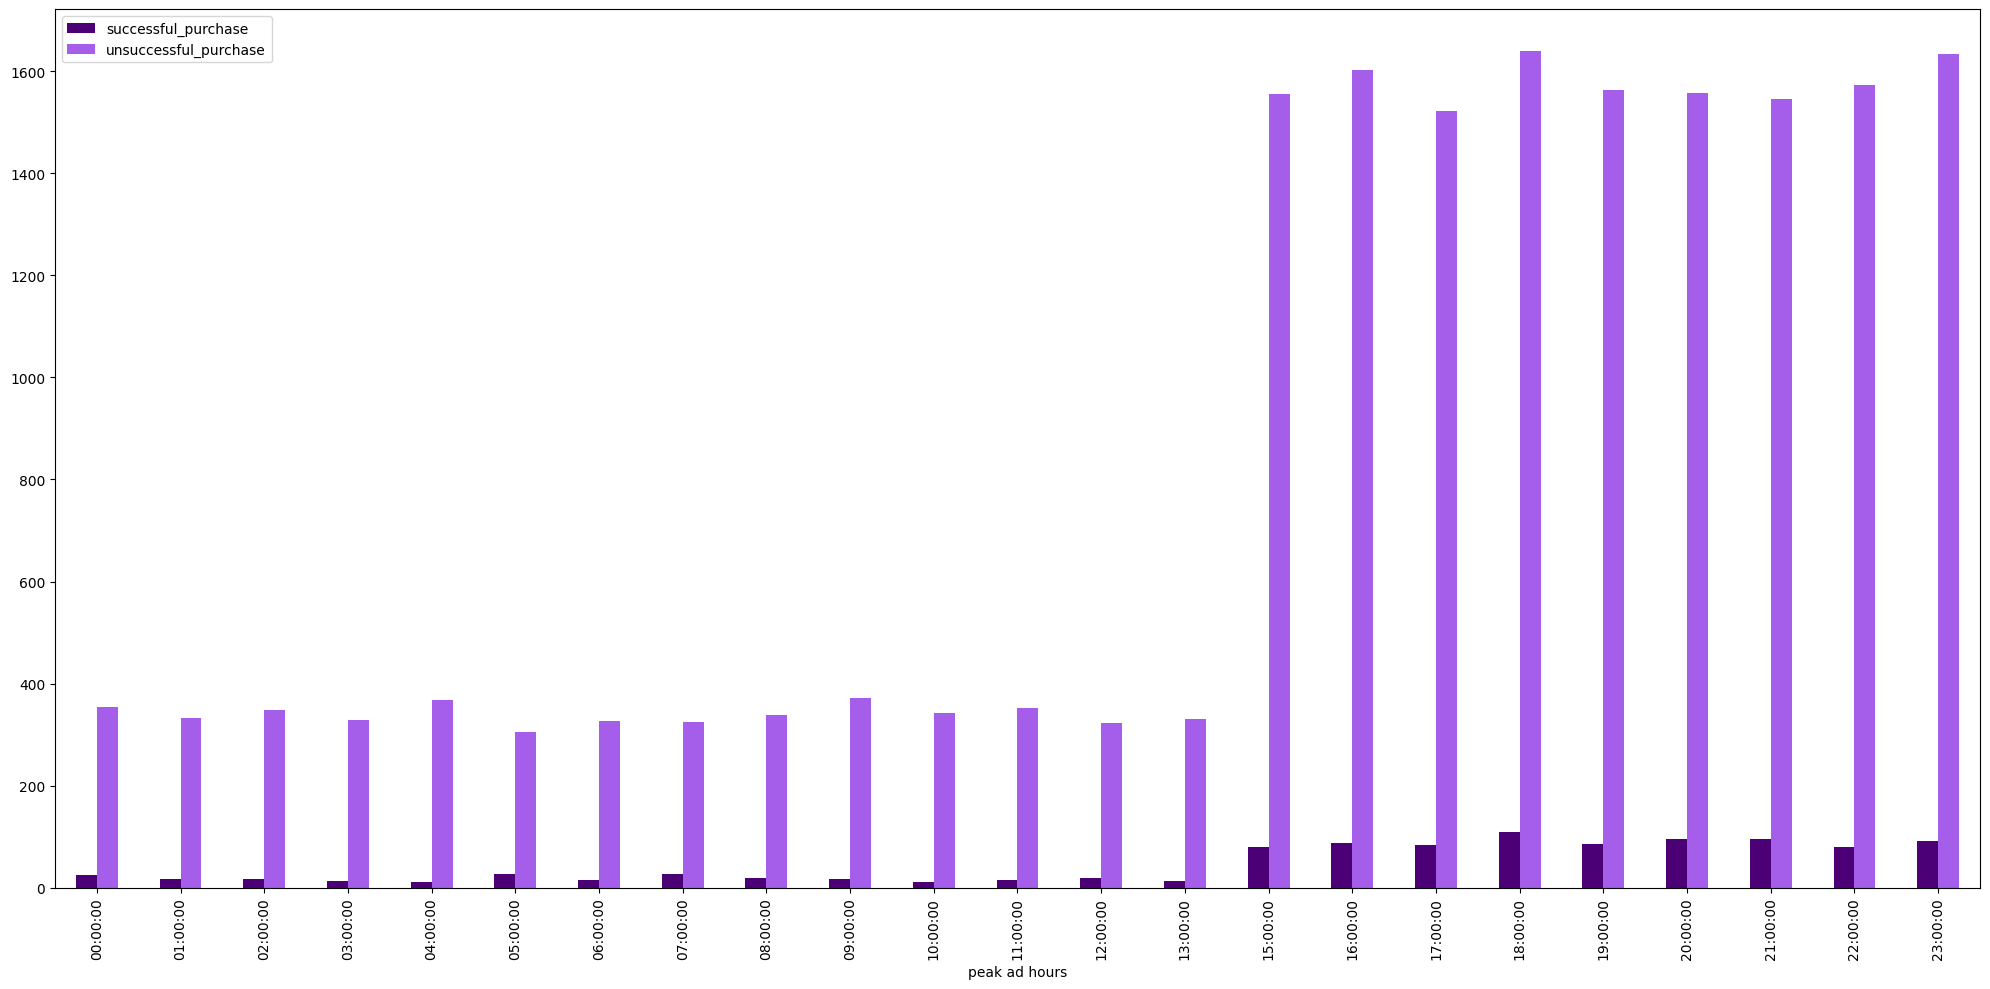

In [333]:

The_plot = pivoted_hourly_purchase.plot(x= 'peak ad hours', y = ['successful_purchase', 'unsuccessful_purchase'], kind = 'bar', color = ['#4B0076','#A45EE9'],figsize =(20,10))
#The_plot.set_xticks(pivoted_hourly_purchase['peak ad hours'])
The_plot.set_xticklabels(pivoted_hourly_purchase['peak ad hours'], rotation = 90)

plt.tight_layout()



##### Most purchases were in the evening, between 3pm  to 11pm. Maybe because peple are coming back from work, school or at home within that period. However, there are less purchase generally.

### Purchase at different times of the day period

In [334]:
grouped_by_daypart = pd.DataFrame(Advert_data.groupby(['daypart','made_purchase']).size().reset_index()) #grouping cnd counting values with size
grouped_by_daypart.columns = ['daypart','Made_purchase', 'count'] # Renaming columns
grouped_by_daypart

,daypart,Made_purchase,count
0,Afternoon,False,3488
1,Afternoon,True,181
2,Early Morning,False,2008
3,Early Morning,True,103
4,Evening,False,3162
5,Evening,True,192
6,Midnight,False,355
7,Midnight,True,25
8,Morning,False,2054
9,Morning,True,111


In [335]:
# Pivoting table
grouped_by_daypart = grouped_by_daypart.pivot(index = 'daypart', columns = 'Made_purchase', values = 'count')
grouped_by_daypart

Made_purchase,False,True
daypart,,
Afternoon,3488,181
Early Morning,2008,103
Evening,3162,192
Midnight,355,25
Morning,2054,111
Night,7873,448


In [336]:
# A bit cleaning 
grouped_by_daypart.columns.name = None # Removing the Made_purchase
grouped_by_daypart

,False,True
daypart,,
Afternoon,3488,181
Early Morning,2008,103
Evening,3162,192
Midnight,355,25
Morning,2054,111
Night,7873,448


In [337]:
grouped_by_daypart.reset_index() #resetind index to make every index columns

,daypart,False,True
0,Afternoon,3488,181
1,Early Morning,2008,103
2,Evening,3162,192
3,Midnight,355,25
4,Morning,2054,111
5,Night,7873,448


In [338]:
grouped_by_daypart.reset_index()
grouped_by_daypart.rename(columns = {False: 'unsuccessful', True:'successful'}, inplace = True)
grouped_by_daypart

,unsuccessful,successful
daypart,,
Afternoon,3488,181
Early Morning,2008,103
Evening,3162,192
Midnight,355,25
Morning,2054,111
Night,7873,448


<Axes: xlabel='daypart'>

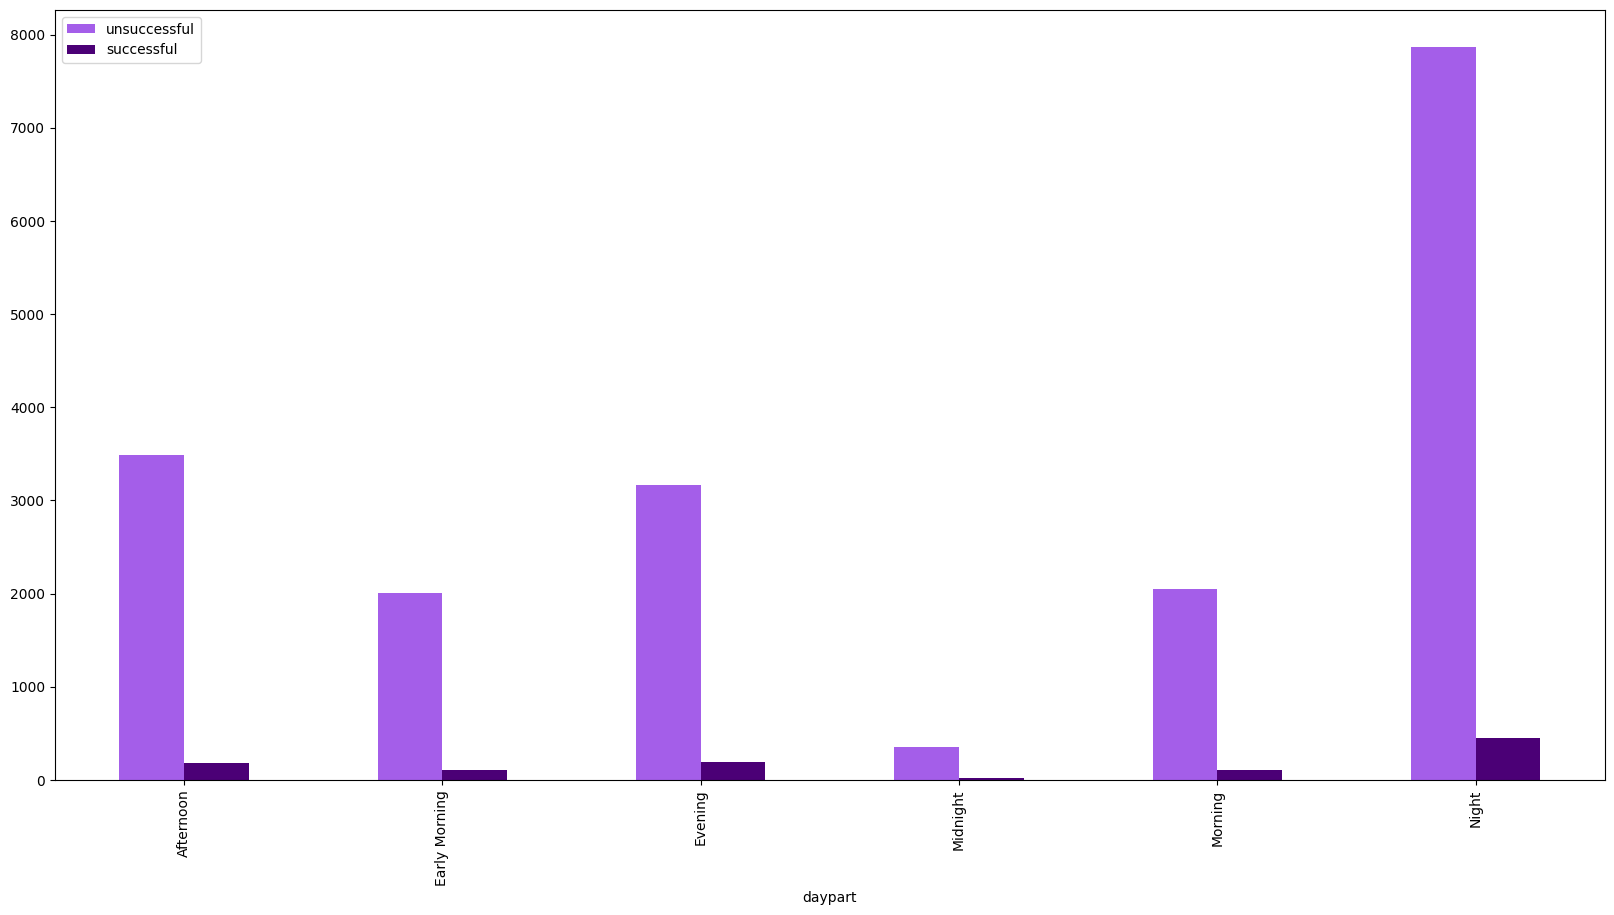

In [339]:
colours = ['#A45EE9','#4B0076']
grouped_by_daypart.plot( kind = 'bar', figsize = (20,10), color = colours)

#### Most Purchases were at Night

## A/B TESTING

* First I need to change create a column to make the True values for purchase 1 and the False value 0

In [340]:
def Made_purchase_to_Numerical (made_purchase):
    if made_purchase == True:
        return 1
    else:
        return 0
    
Advert_data['new_made_purchase'] = Advert_data['made_purchase'].apply(Made_purchase_to_Numerical)
Advert_data.head()

,customerID,test group,made_purchase,days_with_most_add,peak ad hours,ad_count,daypart,new_made_purchase
0,1,ad,False,24,20:00:00,5,Night,0
1,2,psa,False,21,16:00:00,9,Afternoon,0
2,3,psa,False,1,18:00:00,8,Evening,0
3,4,ad,False,20,23:00:00,7,Night,0
4,5,ad,False,3,13:00:00,5,Afternoon,0


In [341]:
# Making sure that no value is left out
Advert_data['new_made_purchase'].unique()

array([0, 1], dtype=int64)

In [342]:
# previously grouped data
grouped_by_test_group

,test group,unsuccessful,successful
0,ad,11250,803
1,psa,7690,257


In [343]:
# knowing Total per awareness method
grouped_by_test_group['Total'] = grouped_by_test_group['unsuccessful'] + grouped_by_test_group['successful']
grouped_by_test_group

,test group,unsuccessful,successful,Total
0,ad,11250,803,12053
1,psa,7690,257,7947


In [344]:
# Knowing percentage suceess.
grouped_by_test_group['success_propotion'] = (grouped_by_test_group['successful']/grouped_by_test_group['Total']) * 100
grouped_by_test_group

,test group,unsuccessful,successful,Total,success_propotion
0,ad,11250,803,12053,6.662242
1,psa,7690,257,7947,3.233925


In [345]:
# To make it look nice and clear by putting percentage.
grouped_by_test_group['success_propotion'] = grouped_by_test_group['success_propotion'].apply(lambda x : f"{x:.2f}%")
grouped_by_test_group

,test group,unsuccessful,successful,Total,success_propotion
0,ad,11250,803,12053,6.66%
1,psa,7690,257,7947,3.23%


#### There seems to be about a bit over 3% differece in success rate for purchaase between the two awarness method, bu I need to know if this is statistically significant.

## STATING HYPOTHESIS

* Ho : There is **No** significant difference between success rate of ad and psa.
* H1 : There is a significant difference between the two method.

## SIGINIFICANT VALUE 
* 5% or 0.05 probability

## GETTING THE PVALUE

In [346]:
Total_ad_success = grouped_by_test_group[grouped_by_test_group['test group']=='ad']['successful'].iloc[0]
Total_ad_success

803

In [347]:
Total_psa_success = grouped_by_test_group[grouped_by_test_group['test group']=='psa']['successful'].iloc[0]
Total_psa_success

257

In [348]:
Total_ad_Total = grouped_by_test_group[grouped_by_test_group['test group']=='ad']['Total'].iloc[0]
Total_ad_Total

12053

In [349]:
Total_psa_Total = grouped_by_test_group[grouped_by_test_group['test group']=='psa']['Total'].iloc[0]
Total_psa_Total

7947

In [350]:
z_score, p_value = sm.stats.proportions_ztest([Total_ad_success, Total_psa_success], [Total_ad_Total, Total_psa_Total])
print(f"Z_score: {z_score},  P_value :{p_value}")

Z_score: 10.590153051109288,  P_value :3.310501343616513e-26


## DECISION MAKING.
* In Hypothesis Testing, we if the p_value of your test is less then the significant value, you will have to reject the **Null Hypothesis**
* If the p_value is greater than the significant value, you will fail to reject the null hypothesis.

For this task, our significant value is **5% or 0.05** and it is bigger than our P_value which is **3.310e-26**. in other words, the p_value for this task is less than the significant value.
Hence, I am **rejecting** the null hypothesis that both method of Awareness (ad and Psa) have the same success rate. Conclusively, the differce between  psa and ad  which showed that ad has higher success rate of a bit over 3% I saw earlier, is **signicant**

## RECOMMENDATION

I think the firm needs to invest more in Advertising even though it will involve Mass media such as billboard, flyers, magazines etc which cost money. I belive from the result of this task that it will increase purchase more than Public Service Anouncement.

# Thank You!